# T/S Diagram from SOSE

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.2.16:34617")
client

Client Scheduler: tcp://10.32.2.16:34617 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 18 Cores: 36 Memory: 207.00 GB


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
%matplotlib inline

In [3]:
ds = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-sose'), consolidated=True)

In [4]:
coords = ds.coords.to_dataset().reset_coords()
dsr = ds.reset_coords(drop=True)

In [5]:
lower_lat = 0
upper_lat = 78
left_lon = 1788
right_lon = 2159

In [6]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

In [7]:
salt = dsr.SALT.isel(**lat_range, **lon_range)
temp = dsr.THETA.isel(**lat_range, **lon_range)

# Juliu's XMovie package

In [8]:
from xmovie import Movie

In [14]:
def custom_plotfunc(dsr, fig, tt, salt=dsr.SALT, temp=dsr.THETA, Z=dsr.Z):

    salt = salt.isel(time=tt, **lat_range, **lon_range)
    temp = temp.isel(time=tt, **lat_range, **lon_range)
    
    _, _, lev_broadcasted = xr.broadcast(salt, temp, Z)
    
    ax = fig.subplots()
    
    scat = ax.scatter(salt, temp, c=abs(lev_broadcasted), marker='.', s=0.5)#, alpha=0.5)<- cheap way to look at vol weighted
    fig.colorbar(scat, label='Depth [m]', shrink=0.8, ticks=np.arange(0, 6000, 1000))

    ax.set_xlim(33.4, 35)
    ax.set_ylim(-2, 1)

    ax.set_xlabel('Salinity [psu]')
    ax.set_ylabel('Potential Temperature [˚C]')
    ax.set_title('T-S Diagram of Weddell Gyre \n 2005-2010 (SOSE)', fontsize=20)
    
    fig.subplots_adjust(top=0.8)
    
    return ax, scat

In [15]:
#creating movie object
mov = Movie(dsr.time, plotfunc=custom_plotfunc, 
            salt=dsr.SALT, temp=dsr.THETA, 
            Z=dsr.Z, input_check=False, dpi=150)
#mov.save('movie.mp4')

In [12]:
#frame preview
mov.preview(3)

In [16]:
#create a movie!

#dsr = dsr.isel(time=slice(0,21))

mov = Movie(dsr.time, plotfunc=custom_plotfunc, 
            salt=dsr.SALT, 
            temp=dsr.THETA, 
            Z=dsr.Z, input_check=False)
mov.save('movie_full.mp4', progress=True)


Movie created at movie_full.mp4


# xhistogram T/S Diagram from SOSE

In [9]:
from xhistogram.xarray import histogram
import numpy as np
from matplotlib.colors import LogNorm

In [33]:
salt_bins = np.linspace(30.5, 35, 100)
theta_bins = np.linspace(-2, 8, 100)
delta_salt = salt_bins[1] - salt_bins[0]
delta_theta = theta_bins[1] - theta_bins[0]

vol = (coords.hFacC * coords.rA * coords.drF).isel(**lat_range, **lon_range)

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


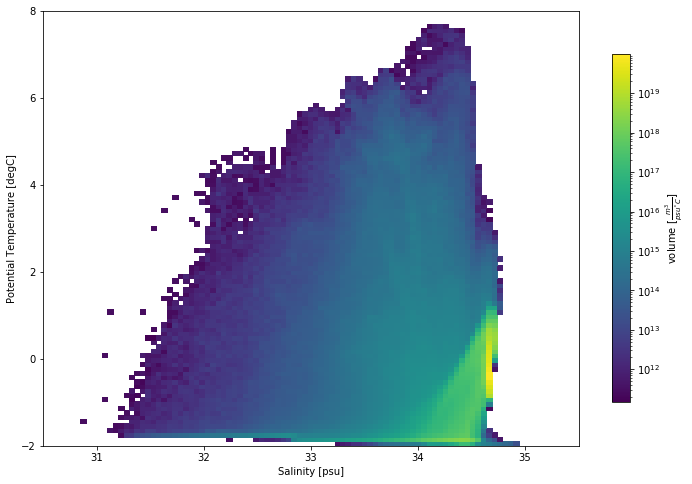

In [38]:
#having `time` dim in the `histogram` func sums over time
ts_hist = histogram(temp, salt, bins=[theta_bins, salt_bins],
                    weights=vol, dim=['XC', 'YC', 'Z', 'time']).rename({'THETA_bin':'theta_bin',
                                                                        'SALT_bin':'salt_bin'}) / (delta_salt * delta_theta)
ts_hist.where(ts_hist>0).plot(norm=LogNorm(), figsize=(12,8), cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

In [39]:
ts_hist = histogram(temp, salt, bins=[theta_bins, salt_bins],
                    weights=vol, dim=['XC', 'YC', 'Z']).rename({'THETA_bin':'theta_bin',
                                                                        'SALT_bin':'salt_bin'}) / (delta_salt * delta_theta)
ts_hist

<xarray.DataArray 'histogram_THETA_SALT' (time: 438, theta_bin: 99, salt_bin: 99)>
dask.array<truediv, shape=(438, 99, 99), dtype=float64, chunksize=(1, 99, 99), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * theta_bin  (theta_bin) float64 -1.949 -1.848 -1.747 ... 7.747 7.848 7.949
  * salt_bin   (salt_bin) float64 30.53 30.58 30.63 30.68 ... 35.37 35.42 35.47

In [40]:
#taking hist mean over `time` takes average (notice the scales are diff in either plots)
ts_hist_mean = ts_hist.mean(dim='time')

Text(0, 0.5, 'Potential Temperature [˚C]')

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


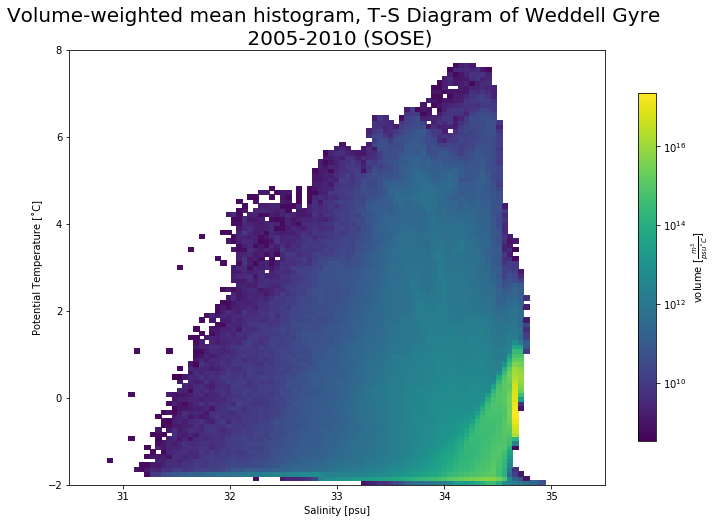

In [42]:
ts_hist_mean.where(ts_hist_mean>0).plot(norm=LogNorm(), figsize=(12,8), cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

plt.title('Volume-weighted mean histogram, T-S Diagram of Weddell Gyre \n 2005-2010 (SOSE)', fontsize=20)
plt.xlabel('Salinity [psu]')
plt.ylabel('Potential Temperature [˚C]')

doing sum (when temp in hist) instead of hist.mean...don't wanna do sum, wanna do mean

* select certain time slice
* use the histogram that didn't sum over `time` dim when making the movie
* play around with the size (spacing) of the bins before normalizing and after to see what the differences are

## Movie!

In [10]:
def xhist_plot(dsr, fig, tt, salt=dsr.SALT, temp=dsr.THETA):

    salt = salt.isel(time=tt, **lat_range, **lon_range)
    temp = temp.isel(time=tt, **lat_range, **lon_range)
    
    salt_bins = np.linspace(30.5, 35, 100)
    theta_bins = np.linspace(-2, 8, 100)
    
    delta_salt = salt_bins[1] - salt_bins[0]
    delta_theta = theta_bins[1] - theta_bins[0]
    
    vol = (coords.hFacC * coords.rA * coords.drF).isel(**lat_range, **lon_range)
    
    ts_hist = histogram(temp, salt, bins=[theta_bins, salt_bins],
                        weights=vol, dim=['XC', 'YC', 'Z']).rename({'THETA_bin':'theta_bin',
                                                                    'SALT_bin':'salt_bin'}) / (delta_salt * delta_theta)
    
    
    #Plotting
    
    ax = fig.subplots()
        
    hist = ax.plot(ts_hist.where(ts_hist>0), norm=LogNorm())#, figsize=(12,8), cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})
    fig.colorbar(hist, label=r'volume [$\frac{m^3}{psu ˚C}$]', shrink=0.8, ticks=np.arange(0, 6000, 1000))

    ax.set_title('Volume-weighted mean histogram, T-S Diagram of Weddell Gyre \n 2005-2010 (SOSE)', fontsize=20)
    ax.set_xlabel('Salinity [psu]')
    ax.set_ylabel('Potential Temperature [˚C]')

    #ax.set_xlim(33.4, 35)
    #ax.set_ylim(-2, 1)
    
    fig.subplots_adjust(top=0.8)
    
    return ax, scat

In [11]:
#creating movie object
mov = Movie(dsr.time, plotfunc=xhist_plot, 
            salt=dsr.SALT, temp=dsr.THETA, input_check=False, dpi=150)
#mov.save('movie.mp4')

AttributeError: 'Line2D' object has no property 'norm'

In [12]:
#frame preview
mov.preview(3)

In [16]:
#create a movie!

#dsr = dsr.isel(time=slice(0,21))

mov = Movie(dsr.time, plotfunc=custom_plotfunc, 
            salt=dsr.SALT, 
            temp=dsr.THETA, 
            Z=dsr.Z, input_check=False)
mov.save('movie_full.mp4', progress=True)


Movie created at movie_full.mp4
